In [42]:
import numpy as np
from pyrosetta import *
init()

from pyrosetta.rosetta.protocols.moves import *
from pyrosetta.rosetta.core.scoring import *
from pyrosetta.rosetta.protocols.simple_moves import *
from pyrosetta.rosetta.protocols.minimization_packing import *

import matplotlib.pyplot as plt

PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python37.mac 2020.02+release.22ef835b4a2647af94fcd6421a85720f07eddf12 2020-01-05T17:31:56] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python37.mac r242 2020.02+release.22ef835b4a2 22ef835b4a2647af94fcd6421a85720f07eddf12 http://www.pyrosetta.org 2020-01-05T17:31:56
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/pyrosetta-2020.2+release.22ef835b4a2-py3.7-macosx-10.9-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=1407314218 seed_offset=0 real_seed=1407314218
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=1407314218 RG_type=mt19937


In [35]:
pose = pose_from_sequence("VIHCDAATICPDGTTCSLSPYGVWYCSPFS")
switch = SwitchResidueTypeSetMover("centroid")
switch.apply(pose)
sfxn = create_score_function("score3")
starting_pose = pose.clone()
sfxn(pose)

156.57643598651632

In [76]:
native_pose = pose_from_pdb("1qgm.pdb")
switch.apply(native_pose)
sfxn(native_pose), CA_rmsd(pose, native_pose)

core.import_pose.import_pose: File '1qgm.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 3 atoms at position 1 in file 1qgm.pdb. Best match rsd_type:  VAL:NtermProteinFull
core.conformation.Conformation: Found disulfide between residues 4 16
core.conformation.Conformation: current variant for 4 CYS
core.conformation.Conformation: current variant for 16 CYS
core.conformation.Conformation: current variant for 4 CYD
core.conformation.Conformation: current variant for 16 CYD
core.conformation.Conformation: Found disulfide between residues 10 26
core.conformation.Conformation: current variant for 10 CYS
core.conformation.Conformation: current variant for 26 CYS
core.conformation.Conformation: current variant for 10 CYD
core.conformation.Conformation: current variant for 26 CYD


(63.8669820863305, 9.485105514526367)

In [89]:
movemap = MoveMap()
movemap.set_bb(True)

n_moves = 1
angles = 30.0
kT = 1.0
rnd_mover = RandomTorsionMover(move_map=movemap, max_angle=angles, num_moves=n_moves)

pose = starting_pose.clone()
mc = MonteCarlo(pose, sfxn, kT)

In [90]:
score_womc = []
score_wmc = []
rmsd = []
for i in range(10000):
    rnd_mover.apply(pose)
    score_womc.append(sfxn(pose))
    mc.boltzmann(pose)
    score_wmc.append(sfxn(pose))
    rmsd.append(CA_rmsd(native_pose, pose))
    
score_womc = np.array(score_womc)
score_wmc = np.array(score_wmc)
rmsd = np.array(rmsd)

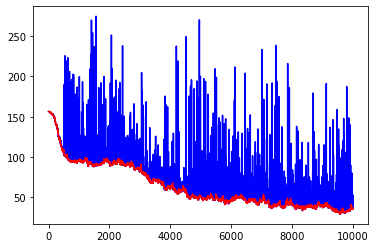

In [91]:
plt.plot(score_womc, color='b')
plt.plot(score_wmc, color='r')
plt.show()

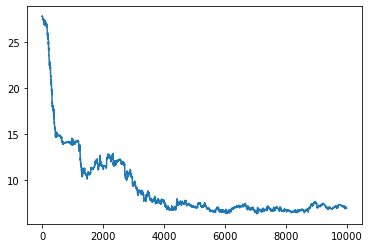

In [92]:
plt.plot(rmsd)
plt.show()

In [60]:
mc.recover_low(pose)

min_mover = MinMover()
min_mover.set_movemap(movemap)
min_mover.score_function(sfxn)

min_mover.apply(pose)
print(sfxn(pose), CA_rmsd(native_pose, pose))

81.42601784545651 10.410965919494629


In [107]:
pose_before = pose.clone()
rnd_mover.apply(pose)
for i in range(1, len(pose.sequence())+1):
    print(i, pose_before.phi(i), pose_before.psi(i), pose.phi(i), pose.psi(i), pose_before.phi(i) == pose.phi(i), pose_before.psi(i) == pose.psi(i))

1 -13.049075176244855 132.6909249760571 -13.049075176244855 132.6909249760571 True True
2 13.635143352971406 103.10321081472898 13.635143352971406 103.10321081472898 True True
3 -101.71022310029306 -167.3247452835602 -101.71022310029306 -167.3247452835602 True True
4 159.7746290818065 -67.84094639409503 159.7746290818065 -67.84094639409503 True True
5 -100.96141597429654 -105.27679758703641 -100.96141597429654 -105.27679758703641 True True
6 -161.67034733872384 -127.42751422937228 -161.67034733872384 -127.42751422937228 True True
7 -134.61368432961117 172.25866895159328 -134.61368432961117 172.25866895159328 True True
8 175.21379686563478 -173.58271617974393 175.21379686563478 -173.58271617974393 True True
9 -143.20025282673973 148.72692529244733 -143.20025282673973 148.72692529244733 True True
10 146.54945772577034 -170.98144207869643 146.54945772577034 -170.98144207869643 True True
11 -164.0837709122837 145.88043827657555 -164.0837709122837 145.88043827657555 True True
12 158.9419523

In [102]:
n_moves = 1
kT = 1.0
small_mover = SmallMover(movemap, kT, n_moves)
shear_mover = ShearMover(movemap, kT, n_moves)

pose_before = pose.clone()
small_mover.apply(pose)
for i in range(1, len(pose.sequence())+1):
    print(i, pose_before.phi(i), pose_before.psi(i), pose.phi(i), pose.psi(i), pose_before.phi(i) == pose.phi(i), pose_before.psi(i) == pose.psi(i))

1 -13.049075176244855 132.6909249760571 -13.049075176244855 132.6909249760571 True True
2 13.635143352971406 103.10321081472898 13.635143352971406 103.10321081472898 True True
3 -101.71022310029306 -167.3247452835602 -101.71022310029306 -167.3247452835602 True True
4 159.7746290818065 -67.84094639409503 159.7746290818065 -67.84094639409503 True True
5 -100.96141597429654 -105.27679758703641 -100.96141597429654 -105.27679758703641 True True
6 -161.67034733872384 -127.42751422937228 -161.67034733872384 -127.42751422937228 True True
7 -134.61368432961117 172.25866895159328 -134.61368432961117 172.25866895159328 True True
8 175.21379686563478 -173.58271617974393 175.21379686563478 -173.58271617974393 True True
9 -143.20025282673973 148.72692529244733 -143.20025282673973 148.72692529244733 True True
10 146.54945772577034 -170.98144207869643 146.54945772577034 -170.98144207869643 True True
11 -164.0837709122837 145.88043827657555 -164.0837709122837 145.88043827657555 True True
12 158.9419523

In [103]:
pose_before = pose.clone()
shear_mover.apply(pose)
for i in range(1, len(pose.sequence())+1):
    print(i, pose_before.phi(i), pose_before.psi(i), pose.phi(i), pose.psi(i), pose_before.phi(i) == pose.phi(i), pose_before.psi(i) == pose.psi(i))

1 -13.049075176244855 132.6909249760571 -13.049075176244855 132.6909249760571 True True
2 13.635143352971406 103.10321081472898 13.635143352971406 103.10321081472898 True True
3 -101.71022310029306 -167.3247452835602 -101.71022310029306 -167.3247452835602 True True
4 159.7746290818065 -67.84094639409503 159.7746290818065 -67.84094639409503 True True
5 -100.96141597429654 -105.27679758703641 -100.96141597429654 -105.27679758703641 True True
6 -161.67034733872384 -127.42751422937228 -161.67034733872384 -127.42751422937228 True True
7 -134.61368432961117 172.25866895159328 -134.61368432961117 172.25866895159328 True True
8 175.21379686563478 -173.58271617974393 175.21379686563478 -173.58271617974393 True True
9 -143.20025282673973 148.72692529244733 -143.20025282673973 148.72692529244733 True True
10 146.54945772577034 -170.98144207869643 146.54945772577034 -170.98144207869643 True True
11 -164.0837709122837 145.88043827657555 -164.0837709122837 145.88043827657555 True True
12 158.9419523

In [113]:
action = np.random.rand(14, 3)
action

array([[4.85803116e-01, 4.13453523e-01, 5.35843980e-01],
       [7.46584017e-01, 6.99064047e-01, 7.33917407e-01],
       [1.81358919e-01, 9.00462570e-01, 9.58433874e-01],
       [8.84303809e-04, 4.54954619e-01, 6.42081641e-03],
       [8.75369591e-01, 8.91073773e-01, 9.37433943e-01],
       [5.98449820e-01, 1.35796448e-01, 3.76928485e-01],
       [7.68477282e-01, 9.89336573e-01, 9.66812778e-01],
       [5.07693670e-01, 1.93804251e-01, 3.96995255e-01],
       [9.54823832e-02, 9.95786150e-01, 7.44998298e-01],
       [8.63585974e-01, 3.95701202e-01, 5.77997029e-01],
       [3.26099938e-01, 9.26896597e-01, 2.25955528e-01],
       [3.40887254e-02, 5.16672392e-02, 6.48144297e-01],
       [2.88365478e-01, 1.47323376e-01, 9.19551971e-01],
       [5.46816790e-01, 4.16251390e-01, 7.91292254e-01]])

In [114]:
action.max()

0.9957861502843363

In [115]:
action.argmax()

25

In [118]:
action.shape[0]

14